In [1]:
#libraries
import numpy as np
import networkx as nx
import networkx.utils as nxu
import matplotlib.pyplot as plt
import scipy.stats as scis
from scipy.optimize import curve_fit
import powerlaw
import numpy.random as ran
import math as mat
from operator import itemgetter
from itertools import product

In [2]:
#variables/params used in code, for containment in particular

N=500 #number of desired nodes
neighbor_sum=np.zeros(N)
m=10 #number of potentially infected nodes at t=0
l=2**m # total number of possiblities 
V=np.zeros((l,m)) #matrix of possible outcomes for containment
nodes=np.zeros(m) #node index associated with neighbor sum
PV=np.zeros((2**m,m))# probability matrix for individual events of nodes being infected at time 0
contact_sum=np.zeros(2**m)#vector containing sums of neighbors for infected nodes for given v_iadj_nodes=np.zeros((m,m))
adj_nodes=np.zeros((m,m)) #adjacency matrix for nodes who are potentially infected at time 0
sum_mat=np.ones((2**m,m,m)) #matrix that holds value for calculation v_ix*v_iy*adj(y_x,y_y)
complete_sum=np.ones(2**m) # sums the ith matrix of sum_mat and stores the value in that vector
t=100 # length of time to run containment over
beta=.25 # probability of infection
mu=.5 #probability of recovery
u=10 # number of increments to update parameter values for examination
P_containment=np.zeros((u,t)) #matrix containing containment probabilities over time and different param values
containment=np.zeros(2**m) # placeholder var that stores individual containment probabilities before summing them
seedval=587994

In [5]:
#graph creation(specifically scale free)
gamma=2.7 #exponent of powerlaw
No =700# of nodes need to create more than needed
z=(nxu.powerlaw_sequence(No,exponent=gamma,))
Z=[round(x) for x in z]
Tries=0
giant = nx.Graph()
while  np.sum(Z)%2 !=0 or  len(giant) != 500 :#makes sure sum adds to even value and graph is connected
    if Tries > 2000:
        print('Number of attempts exceeded')
        break
    z=(nxu.powerlaw_sequence(No,exponent=gamma))
    Z=[round(x) for x in z] #rounds powerlaw_sequence to int
    if np.sum(Z)%2 == 0:
        G = nx.configuration_model(Z) #uses configuration model to create graph
        G=nx.Graph(G)#removes parallel edges between nodes
        G.remove_edges_from(nx.selfloop_edges(G))
        giant = max(nx.connected_component_subgraphs(G), key= len)
    Tries +=  1


print(nx.is_connected(giant))
print(len(giant)) #obtains largest connected component of scale-free network.
F=list(nx.degree(giant))#converts graph into list of 2-tuples
max_degree = max(F,key=itemgetter(1)) #itemgetter makes sure is found from 2nd-tuple i.e. max degree
#min degree tends to be just 1
print(max_degree)

True
500
(461, 44)


In [3]:
#snippet to keep seedval from prior graph creation

gamma=2.7 #exponent of powerlaw
giant=nx.Graph()
No =700# of nodes need to create more than needed
z=(nxu.powerlaw_sequence(No,exponent=gamma,seed=587994))
Z=[round(x) for x in z] #rounds powerlaw_sequence to int
while len(giant) != 500:
    G = nx.configuration_model(Z) #uses configuration model to create graph
    G=nx.Graph(G)#removes parallel edges between nodes
    G.remove_edges_from(nx.selfloop_edges(G))
    giant = max(nx.connected_component_subgraphs(G), key= len)
print(len(giant))
print(nx.is_connected(giant))

500
True


In [6]:
#adjacency matrix, neigbhor sum creation
adj=nx.to_numpy_array(giant)
#neighbor_sum=np.zeros(500)
for x in range (0, len(neighbor_sum)):
    neighbor_sum[x]=sum(adj[x,:])
    


In [7]:
# creating scenarios of V
#m=10 #number of potentially infected nodes at t=0
#l=2**m # total number of possiblities 
prod=product([0,1],repeat=m) #obtains cartesian product when repetitions are of size m
prod_list=list(prod)
#V=np.zeros((l,m))
for i in range(0,len(prod_list)):
    V[i,:]=np.asarray(prod_list[i])


In [8]:
#setting up sorted neighbor sum, 
sort_neighbor_sum=-np.sort(-neighbor_sum) # sorts in descending order
most_connected=sort_neighbor_sum[0:m]
least_connected=sort_neighbor_sum[-m:]




In [109]:
#reverse look up to find index associated with neighbor for most connected
#nodes=np.zeros(m)
for x in range(0,m):
    hold=np.where(neighbor_sum==most_connected[x])
    hold_array=np.asarray(hold[0])
    for y in range(0,len(hold_array)):
        if hold_array[y] in nodes:
            continue
        else:
            nodes[x]=hold_array[y]
            break 
             
    



In [100]:
#reverse look up to find index associated with neighbor for least connected
#nodes=np.zeros(m)
for x in range(0,m):
    hold=np.where(neighbor_sum==least_connected[x])
    hold_array=np.asarray(hold[0])
    for y in range(0,len(hold_array)):
        if hold_array[y] in nodes:
            continue
        else:
            nodes[x]=hold_array[y]
            break 


In [ ]:
a=.3 #default for iid bernoulli, will change to independent later
for x in range(0, 2**m): 
    for y in range (0,m):
        if V[x,y] == 1:
            PV[x,y]=a
        else:
            PV[x,y]=1-a

In [20]:
#arbitrary probability for each member
np.random.seed(300)
O_prob=np.random.rand(m)
for x in range(0, 2**m): 
    for y in range (0,m):
        if V[x,y] == 1:
            PV[x,y]=O_prob[y]
        else:
            PV[x,y]=1-O_prob[y]

In [110]:
#setting up formula for implementation of most connected
#PV=np.zeros((2**m,m))# probability matrix for individual events of nodes being infected at time 0
#contact_sum=np.zeros(2**m)#vector containing sums of neighbors for infected nodes for given v_iadj_nodes=np.zeros((m,m))
#adj_nodes=np.zeros((m,m)) #adjacency matrix for nodes who are potentially infected at time 0
#sum_mat=np.ones((2**m,m,m)) #matrix that holds value for calculation v_ix*v_iy*adj(y_x,y_y)
#complete_sum=np.ones(2**m) # sums the ith matrix of sum_mat and stores the value in that vector

            
for x in range(0,2**m):
    contact_sum[x]=sum(V[x]*most_connected)
nodes=nodes.astype(np.int) #need nodes to be int in order to index correctly   
for x in range(0,m):
    for y in range(0,m):
        adj_nodes[x,y]=adj[nodes[x],nodes[y]]
for i in range(0,2**m):
    for x in range(0,m):
        for y in range(0,m):
            sum_mat[i,x,y]=V[i,x]*V[i,y]*adj_nodes[x,y]
for i in range (0,2**m):
    complete_sum[i]=np.sum(sum_mat[i,:,:])
        

In [101]:
#set up for least connected
for x in range(0,2**m):
    contact_sum[x]=sum(V[x]*least_connected)
nodes=nodes.astype(np.int) #need nodes to be int in order to index correctly   
for x in range(0,m):
    for y in range(0,m):
        adj_nodes[x,y]=adj[nodes[x],nodes[y]]
for i in range(0,2**m):
    for x in range(0,m):
        for y in range(0,m):
            sum_mat[i,x,y]=V[i,x]*V[i,y]*adj_nodes[x,y]
for i in range (0,2**m):
    complete_sum[i]=np.sum(sum_mat[i,:,:])
        

In [98]:
# probability of containment calculation with varying beta
#t=100
#beta=.01
mu=.5
#u=10
#P_containment=np.zeros((u,t))
#containment=np.zeros(2**m)
for z in range(0,10):
    beta=.1+z*.1
    for x in range(0,t):
        a=1+x
        for i in range(0,2**m):
            containment[i]=np.prod(PV[i])*(1-mu)**(a*sum(V[i]))*(1-beta)**(a*((sum(V[i]*most_connected))-complete_sum[i]))
            if i == 2**m-1:
                P_containment[z,x]=sum(containment)-np.prod(PV[0]) #eliminates case where infection never occurs
    
    

In [102]:
#with least connected,varying beta
mu=.5
for z in range(0,10):
    beta=.1+z*.1
    for x in range(0,t):
        a=1+x
        for i in range(0,2**m):
            containment[i]=np.prod(PV[i])*(1-mu)**(a*sum(V[i]))*(1-beta)**(a*((sum(V[i]*least_connected))-complete_sum[i]))
            if i == 2**m-1:
                P_containment[z,x]=sum(containment) -np.prod(PV[0])
    

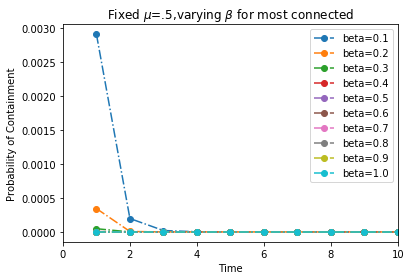

In [99]:
#graph of containment length t, varying beta
x_axis=list(range(1,t+1))
plt.xlim(0,10)
plt.title(r'Fixed $\mu$=.5,varying $\beta$ for most connected')
plt.xlabel('Time')
plt.ylabel('Probability of Containment')
for x in range (0,10):
    plt.plot(x_axis,P_containment[x,:],'-.o',label='beta='+str(np.round(.1+.1*x,decimals=1)))

plt.legend()


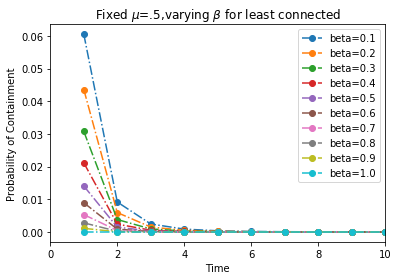

In [105]:
#least connected fixed mu varying beta plot
plt.xlim(0,10)
plt.title(r'Fixed $\mu$=.5,varying $\beta$ for least connected')
plt.xlabel('Time')
plt.ylabel('Probability of Containment')
for x in range (0,10):
    plt.plot(x_axis,P_containment[x,:],'-.o',label='beta='+str(np.round(.1+.1*x,decimals=1)))

plt.legend()



In [61]:
#vectorized version of code does work,implement from now on
A=np.prod(PV,axis=1)
B=np.sum(V,axis=1)
C=np.sum(V*most_connected,axis=1)
D=A*(1-mu)**(2*B)*(1-.1)**(2*(C-complete_sum))
E=np.zeros((10,10))
for v in range(0,10):
    beta=.1+.1*v
    for t in range(0,10):
        a=1+t
        D=A*(1-mu)**(a*B)*(1-beta)**(a*(C-complete_sum))
        E[v,t]=sum(D)

In [111]:
#probability of containment with varying mu most connected 
beta=.25#need to set beta prob back 
for z in range(0,10):
    mu=.1+z*.1
    for x in range(0,t):
        a=1+x
        for i in range(0,2**m):
            containment[i]=np.prod(PV[i])*(1-mu)**(a*sum(V[i]))*(1-beta)**(a*((sum(V[i]*most_connected))-complete_sum[i]))
            if i == 2**m-1:
                P_containment[z,x]=sum(containment)-np.prod(PV[0])

In [106]:
#probability of containment with varying mu with least connected
beta=.25 #need to set beta prob back 
for z in range(0,10):
    mu=.1+z*.1
    for x in range(0,t):
        a=1+x
        for i in range(0,2**m):
            containment[i]=np.prod(PV[i])*(1-mu)**(a*sum(V[i]))*(1-beta)**(a*((sum(V[i]*least_connected))-complete_sum[i]))
            if i == 2**m-1:
                P_containment[z,x]=sum(containment)-np.prod(PV[0])

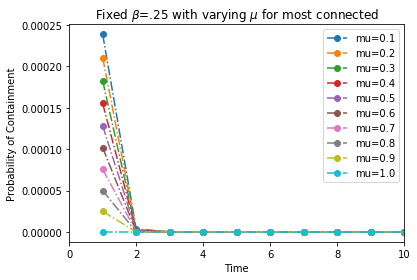

In [112]:
#graph of varying mu over length t with most connected

plt.title(r'Fixed $\beta$=.25 with varying $\mu$ for most connected')
plt.xlim(0,10)
plt.xlabel('Time')
plt.ylabel('Probability of Containment')
for y in range (0,10):
    plt.plot(x_axis,P_containment[y,:],'-.o',label='mu='+str(np.round(.1+.1*y,decimals=1)))
plt.legend()


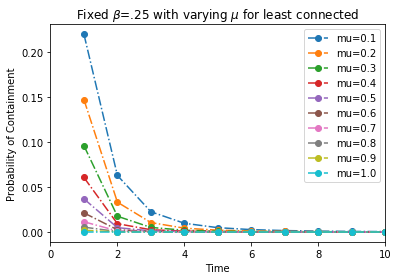

In [108]:
#graph of varying mu over length t with least connected

plt.title(r'Fixed $\beta$=.25 with varying $\mu$ for least connected')
plt.xlim(0,10)

plt.xlabel('Time')
plt.ylabel('Probability of Containment')
for y in range (0,10):
    plt.plot(x_axis,P_containment[y,:],'-.o',label='mu='+str(np.round(.1+.1*y,decimals=1)))
plt.legend()
